![MOSEK ApS](https://mosek.com/files/mosek_logo_color.png )


## Risk Parity Portfolio Selection using MOSEK Optimizer API


Portfolio selection (or portfolio management) is the art and science of making decisions about investment mix and policy, matching investments to objectives, asset allocation for individuals and institutions, and balancing risk against performance.

The aim of this tutorial is two-fold:

1. to show some modeling techniques to define portfolio selections problems;
2. to show how to efficiently implement those problems using MOSEK Optimizer API.


This tutorial is largerly based on:

    [1] Bai, X., Scheinberg, K., Tutuncu, R. (2013). Least-squares approach to risk parity in portfolio selection

The code is written in Python2 and uses the [MOSEK Optimizer API](https://mosek.com/resources/doc) version 7.1.

# Risk Parity

Consider the problem of an investor, who has to invest his money in $n$ different assets. Which allocation strategy should he use to obtain the maximum $\textit{benefit}$ from his investment?

Let $x_i$ be the percentage of money invested in assets $i$, and $\mu_i$ its expected return. Let assume we know the covariance matrix $\Sigma$ that link the assets together. We can then define two global measures of the portfolio performance:

$$
\mu =\sum_{i=1}^n \mu_i x_i, 
$$

and 

$$
\sigma^2 = \sum_{i=1}^n \sum_{j=1}^n \Sigma_{i,j}x_i x_j = x^T \Sigma x.
$$

For different choices of $x_i$ the investor will get different combinations of $\mu$ and $\sigma^2$. The set of all possible ($\sigma^2$, $\mu$) combinations is called the $\textit{attainable set}$.

With $\textit{risk}$ is intended a measurement of the likelihood that an investment will go up and down in value, and how often and by how much. The theory assumes that investors prefer to minimize risk; in fact, it assumes that given the choice of two portfolios with equal returns, investors will choose the one with the least risk.

In a fully-invested portfolio, every asset $i$ has his contribution in terms of risk. Let $RC_i(x)$ be this contribution, we have that the total risk of the invested portfolio is:

$$
\mathcal{R}(x) = \sum_{i=1}^n RC_i(x)
$$

where

$$
RC_i(x) = x_i \frac{\partial \mathcal{R}(x)}{\partial x_i}
$$

Let $b=(b_1,..,b_n)$ be a vector of $\textbf{budgets}$ such as $b_i > 0$ and $\sum_{i=1}^n b_i = 1$. We define a **risk parity** (or risk budgeting) portfolio as the solution of the following set of equations:

$$
\begin{aligned}
&\begin{cases}
RC_1(x) = b_1 \mathcal{R}(x)\\
..\\
RC_i(x) = b_i \mathcal{R}(x)\\
..\\
RC_n(x) = b_n \mathcal{R}(x)
\end{cases}
\end{aligned}
$$

From the above equations, we can write the risk parity constraint as:

$$
\frac{x_i}{b_i} \frac{\partial \mathcal{R}(x)}{\partial x_i} = \frac{x_j}{b_j} \frac{\partial \mathcal{R}(x)}{\partial x_j} \hspace{1em} \forall i,j
$$

The Risk Parity portfolio is defined by this system of equations:

$$
\begin{aligned}
&\frac{x_i}{b_i} \frac{\partial \mathcal{R}(x)}{\partial x_i} = \frac{x_j}{b_j} \frac{\partial \mathcal{R}(x)}{\partial x_j} && \forall i,j\\
&x_i \geq 0,  &&b_i > 0 \\
&\sum_{i=1}^n x_i = 1,  &&\sum_{i=1}^n b_i = 1
\end{aligned}
$$

If we set

$$
\mathcal{R}(x) = \sqrt{x^T\Sigma x}
$$

solving the following problem that incorporates a logarithmic barrier in the objective function is equivalent to find a Risk Parity solution:

$$
\begin{equation}
\begin{array}{l}
    \min_x \frac{1}{2} x^T \Sigma x - c \sum_{i=1}^{n} b_i ln(x_i)\\
    \text{s.t.}\\
    x > 0 
        \end{array}
\end{equation}
$$

where $b_i > 0$, $\sum_i b_i = 1$ and $c$ is a positive constant.

### Proof

Since $\Sigma$ is positive semidefinite and the logarithm function is strictly concave, the objective function is $\textbf{strictly convex}$. From the first order condition, the unique solution is in corrispondence of the point where the gradient of the objective function is zero:

$$
\Sigma x - c b_i x^{-1} = 0
$$

Hence, at optimality we have

$$
(\Sigma x)_i = \frac{c b_i}{x_i} \Rightarrow \frac{x_i(\Sigma x)_i}{b_i} = \frac{x_j(\Sigma x)_j}{b_j}, \quad \forall i,j,
$$

since 

$$
\frac{\partial \mathcal{R}(x)}{\partial x_i} = (\Sigma x)_i.
$$


# MOSEK Implementation

First of all, we have to import the MOSEK library into the project. Before setting up the optimization problem, a MOSEK $\textbf{environment}$ must be created. All tasks in the program should share the same environment (go to <a href="http://docs.mosek.com/7.1/pythonapi/index.html">MOSEK Optimizer API Documentation</a> for further information).

In [1]:
import mosek
import numpy as np

env = mosek.Env()

Next, an empty $\textbf{task}$ object is created:

In [2]:
task = env.Task()

Now, we create some sample data. In this case we have 10 assets and we randomly generate a semidefinite-positive covariance matrix and the budget vector.

In [3]:
n = 10

A = np.random.sample([n,n])

#Q is our covariance matrix
Q = np.dot(A,A.transpose())

#b is the vector of budgets 
b = np.random.sample(n)
b = b/np.sum(b)

For this type of problem, we have $n$ variables and $1$ constraint. So we set them into the task:

In [4]:
numvar = n
numcon = 1

task.appendvars(numvar)
task.appendcons(numcon)

We have to write the constraint $x>0$. The bounds on variables are stored in the arrays:

In [5]:
# Bound keys for variables 
bkx = [mosek.boundkey.lo] * n
    
# Bound values for variables 
blx = np.zeros(n)
bux = [np.infty] * n

Now we have to set the bounds for every variable $x_j$:

In [6]:
task.putvarboundslice(0, numvar, bkx, blx, bux)

The next step is to write down the objective function. Since the covariance matrix $\Sigma$ is symmetric, we can use only his upper-triangle:

In [7]:
#extract the indexes of the upper-triangle of the covariance matrix
indexes = np.tril_indices(numvar)
qsubi = indexes[0]
qsubj = indexes[1]

#create the upper-triangle matrix with the indexes previously extracted
qval = np.tril(Q)[indexes]

Now, we can add the first part of the objective function to the task:

In [8]:
task.putqobj(qsubi,qsubj,qval)

Now, we have to add the logarithmic term to the objective function. MOSEK provides a simple interface for separable convex optimization problems, named `SCopt`, in which our problem perfecly fits. See [official docs](http://docs.mosek.com/7.1/pythonapi/Separable_convex_SCopt_interface.html).

In `SCopt` each function must be expressed as sum of separable terms, i.e. simple univariate functions. IN the case of the logarithm, we can input a term of the form

$$
    f \ln(g\cdot x + h),
$$

where $f,g,h$ are constants choosen in a way the function must be concave. In our case $f=1$, $g=1$ and $h=0$.

In terms of implementation we do

In [9]:
#define the logarithm for n variables
opro = [mosek.scopr.log] * n 

#define the variable indexes
oprjo = np.array([i for i in range(n)])

#define the multiplicative term (in this case we assume c=1)
oprfo = -b

#define the exponential terms
oprgo = np.ones(n)

#define the additive terms
oprho = np.zeros(n)

We can now build the separable term using the function:

In [10]:
task.putSCeval(opro, oprjo, oprfo, oprgo, oprho)

Now we have to tell to the optimizer that this is a minimization problem:


In [11]:
# Input the objective sense (minimize/maximize) 
task.putobjsense(mosek.objsense.minimize) 

Finally, we call the optimization routine:

In [12]:
task.optimize()

ok

# Results

We can access to the optimal solution found through two simple instructions:

In [13]:
xx = np.zeros(numvar, float)
task.getxx(mosek.soltype.itr,xx)

If we also want that $\sum_{i=1}^n x_i = 1$ we normalize the solution:

In [14]:
xx = xx/np.sum(xx)

Now we can see the Risk Parity solution in a bar chart:

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot_bar(xx, c, title, xlabel, ylabel):
    n = len(xx)
    ind = np.arange(n)
    width = 1
    fig, ax = plt.subplots()
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    ax.set_xticks(ind + 0.5)
    ax.set_xticklabels(ind)
    rects1 = ax.bar(ind, xx, width, color=c)
    bound = np.abs( np.max( np.abs(np.min(xx)), np.abs(np.max(xx))) )
    #if np.min(xx)<0:
    plt.axis( [0, n, -1.1*bound, 1.1*bound])# if np.min(xx)<0. else [0, n, 0, 1.1*bound])
    plt.show()
                 
# the histogram of the data
plot_bar(xx, 'r', 'Risk Parity Solution', 'Assets', 'Weight')


A Risk Parity solution satisfies the following equation:
    
$$
\frac{RC_i(x)}{x^T \Sigma x} = b_i \quad \forall i \in \{1,..,n\}
$$

To verify that this is really a Risk Parity solution, we now compute the marginal risk contributions for all assets:

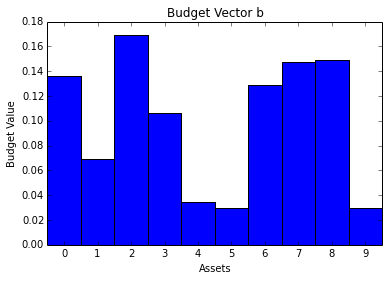

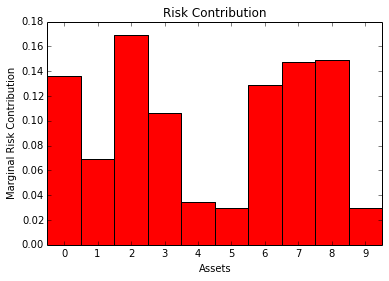

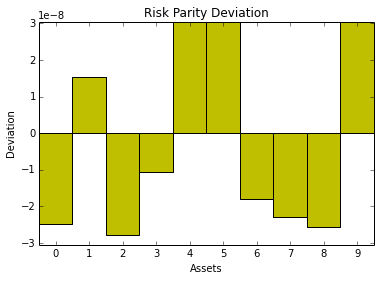

In [16]:

aux = Q.dot(xx)
volatility = xx.dot(aux)

RC = (xx*aux)/volatility
    
#print budget vector
plot_bar(b, 'b', 'Budget Vector b', 'Assets', 'Budget Value')

#print marginal risk contribution
plot_bar(RC, 'r', 'Risk Contribution', 'Assets', 'Marginal Risk Contribution')

#print the differences between the two above
plot_bar(RC-b, 'y', 'Risk Parity Deviation', 'Assets', 'Deviation')



# Summary

In this notebook we showed how to cast in convex for the basic Risk Parity Portfolio problem. We then use the MOSEK SCopt Python interface to solve the problem. A simpler numerical example shows that the problem can be easily solved.

Further improvements may come from exploting sparsity in the covariance matrix. Additional constraints may be included, but the equivalence between of the convex formulation may not hold.


<a rel="license" href="http://creativecommons.org/licenses/by-nc-nd/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-nc-nd/4.0/88x31.png" /></a><br /><span xmlns:dct="http://purl.org/dc/terms/" property="dct:title">MOSEK Optimizer API Notebook</span> is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc-nd/4.0/">Creative Commons Attribution-NonCommercial-NoDerivatives 4.0 International License</a>.